In [46]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import random as rd

In [47]:
def load_images(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [48]:
def mtb_align_images(images):
    # Convert images to grayscale
    gray_images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

    # Resize images to the same size
    min_height = min([img.shape[0] for img in gray_images])
    min_width = min([img.shape[1] for img in gray_images])
    gray_images = [cv.resize(img, (min_width, min_height)) for img in gray_images]

    # Compute median values of images
    medians = [np.median(img) for img in gray_images]

    # Compute threshold values
    thresholds = [abs(medians[i] - medians[j]) / 6 for i in range(len(images)) for j in range(i+1, len(images))]

    # Create binary images using threshold
    binary_images = [cv.threshold(gray_images[i], medians[i] + thresholds[j], 255, cv.THRESH_BINARY)[1] for i in range(len(images)) for j in range(i+1, len(images))]

    # Compute pairwise offsets between images
    pairwise_offsets = [np.unravel_index(np.argmax(cv.matchTemplate(binary_images[i], binary_images[j], cv.TM_CCORR_NORMED)), binary_images[i].shape) for i in range(len(images)) for j in range(i+1, len(images))]

    # Compute total offsets for each image
    total_offsets = [np.sum(pairwise_offsets[i:len(images)-1], axis=0) for i in range(len(images)-1)]
    total_offsets.insert(0, np.zeros(2, dtype=int))

    # Align images using total offsets
    aligned_images = [cv.warpAffine(images[i], np.float32([[1, 0, -total_offsets[i][1]], [0, 1, -total_offsets[i][0]]]), (images[i].shape[1], images[i].shape[0])) for i in range(len(images))]

    return aligned_images


In [49]:
# def sample_pixels(images, num_samples):
    
#     # Choose pixels with largest standard deviation
#     stds = np.std(images, axis=0)
#     selected_pixel_value = np.argsort(stds.ravel())[::-1][:num_samples]
#     sampled_pixels = np.unravel_index(selected_pixel_value, stds.shape) 
#     # returns (i of chosen pixels, j of chosen pixels)
    
#     # Compute the sample values for each pixel
#     samples = np.zeros((num_samples, len(images)), dtype=np.int0)
#     for i in range(num_samples):
#         x, y = sampled_pixels[0][i], sampled_pixels[1][i]
#         for j in range(len(images)):
#             samples[i, j] = images[j][x, y]
    
#     return samples
#     # returns [ [first chosen pixel in every image], [], ..... [] ]

# def sample_pixels(images, num_samples):
#     height = len(images[0]) 
#     width = len(images[0][0])
#     samples = np.zeros((num_samples, len(images)), dtype=np.int0)
#     for i in range(num_samples):
#         y = rd.randint(0,width-1)
#         x = rd.randint(0,height-1)
#         for j in range(len(images)):
#             samples[i, j] = images[j][x, y]
            
#     return samples

def sample_pixels(images, num_samples):
    
    # Divide the image into 100x100 areas
    step = 25
    x_starts = np.arange(0, images[0].shape[0], step)
    y_starts = np.arange(0, images[0].shape[1], step)
    
    # Choose pixels with largest standard deviation in each area
    sampled_pixels = []
    for x in x_starts:
        for y in y_starts:
            x_end = min(x+step, images[0].shape[0])
            y_end = min(y+step, images[0].shape[1])
            subimages = [img[x:x_end, y:y_end] for img in images]
            stds = np.std(subimages, axis=0)
            max_idx = np.argmax(stds)
            max_pos = np.unravel_index(max_idx, stds.shape)
            sampled_pixels.append((x+max_pos[0], y+max_pos[1]))
            
            if len(sampled_pixels) == num_samples:
                break
                
        if len(sampled_pixels) == num_samples:
            break
    
    # Compute the sample values for each pixel
    samples = np.zeros((num_samples, len(images)), dtype=np.int0)
    for i, pixel_pos in enumerate(sampled_pixels):
        x, y = pixel_pos
        for j in range(len(images)):
            samples[i, j] = images[j][x, y]
    
    return samples


In [50]:
# def solve_respond_curve(z,lgT,lam,w):
#     #z : ith pixel of those chosen in jth image
#     n = len(z) #n : we choose n pixels total for each images
#     p = len(z[0])#p : we choose p images total 
#     row = n*p + 1 + 254
#     col = 256 + n   # row and col in matrix a
#     a = [[] for i in range(row)]
#     b = [[] for i in range(row)]
    

#     #initialize matrix a(zero) and b(zero)
#     for i in range(row):
#         b[i].append(0)
#         for j in range(col):
#             a[i].append(0)

#     #upper half of matrix a and b done
#     for j in range(p):
#         for i in range(n):
#             Z = int(z[i][j])
#             b[i+j*n][0] = lgT[j] * w[Z]
#             for r in range(256):
#                 if r == Z :
#                     a[i+j*n][r] = 1 * w[Z]
#             a[i+j*n][256+i] = -1 * w[Z]

#     #fix the curve by setting its middle value to 0
#     a[n*p][129] = 1

#     #lower half of matrix a and b done
#     for k in range(n*p+1,n*p+255):
#         for l in range(255):
#             a[k][l] = 1 * w[l+1] * lam 
#             a[k][l+1] = -2 * w[l+1] * lam 
#             a[k][l+2] = 1 * w[l+1] * lam 
            
    
#     A = np.array(a)
#     B = np.array(b)
#     #Solve the system using SVD
#     x = np.linalg.lstsq(A,B,rcond = None)[0]
#     g = x[:256]
#     lE = x[256:]
    
#     return g, lE

# import numpy as np

def solve_respond_curve(Z, B, l, w):
    n = 256
    A = np.zeros((Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0]))
    b = np.zeros((A.shape[0],1))
    k = 0 # Include the data-fitting equations
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i,j]]
            A[k,Z[i,j]] = wij
            A[k,n+i] = -wij
            b[k] = wij * B[j]
            k += 1
    A[k, 129] = 1
    k += 1
    for i in range(n-2):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2*l*w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1
    x = np.linalg.lstsq(A, b, rcond=None)[0] # Solve the system using SVD
    g = x[:n]
    lE = x[n:]
    return g, lE


In [51]:
def radiance(w,z,g,ln_t): 
    p = len(z) #p : we choose p images total 
    N = len(z[0])#N : total N pixels for each images
    lnE = [0]*N#initial lnEi
    E = [0]*N
    
    for i in range(N):
        top = 0 #each i 分子 initial
        bottom = 0 #each i 分母 initial
        for j in range(p):
            Z = z[j][i]
            top += w[Z]*(g[Z]-ln_t[j])
            bottom += w[Z]
        
        lnE[i] = (top/bottom)[0] if bottom > 0 else top
        E[i] = math.exp(lnE[i])
    #print(lnE)
    return E


In [52]:
def show_false_color(images, gb, gg, gr, ln_t):
    # Construct radiance map for each channels
    p = len(images) #how many images total
    height = len(images[0]) #height and width, should be same for eahc image
    width = len(images[0][0])
    hdr = np.zeros((height, width, 3),'float32') #real exposure array, 3 channel for all images
    # ln_t = math.log(exposure_times)
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]


    #real exposure mapping of channel B for all images
    Zb = [[] for i in range(p)]
    Zb = [img[...,0].flatten().tolist() for img in images]
    Eb = radiance(w,Zb,gb,ln_t)
    hdr[...,0] = np.reshape(Eb, (height,width))
    
    #real exposure mapping of channel G for all images
    Zg = [[] for i in range(p)]
    Zg = [img[...,1].flatten().tolist() for img in images]
    Eg = radiance(w,Zg,gg,ln_t)
    hdr[...,1] = np.reshape(Eg, (height,width))

    #real exposure mapping of channel R for all images
    Zr = [[] for i in range(p)]
    Zr = [img[...,2].flatten().tolist() for img in images]
    Er = radiance(w,Zr,gr,ln_t)
    hdr[...,2] = np.reshape(Er, (height,width))

    cmap = plt.cm.get_cmap('jet')
    max_val = np.max(hdr, axis=(0, 1))
    hdr_norm = hdr / max_val
    img_gray = cv.cvtColor(hdr_norm,cv.COLOR_BGR2GRAY)
    plt.imshow(img_gray, cmap=cmap)
    plt.colorbar()
    plt.axis('off')
    plt.savefig('false-color.png')
    

    return hdr

    

In [53]:
def tone_mapping(hdr_image):

    # Create an instance of the Reinhard tonemapping algorithm
    tonemap = cv.createTonemapReinhard()

    # Set the gamma value
    gamma = 1.2

    # Apply gamma correction to the tonemapped image
    tonemap.setGamma(gamma)

    # Tonemap the HDR image using the Reinhard algorithm with gamma correction
    ldr_image = tonemap.process(hdr_image)



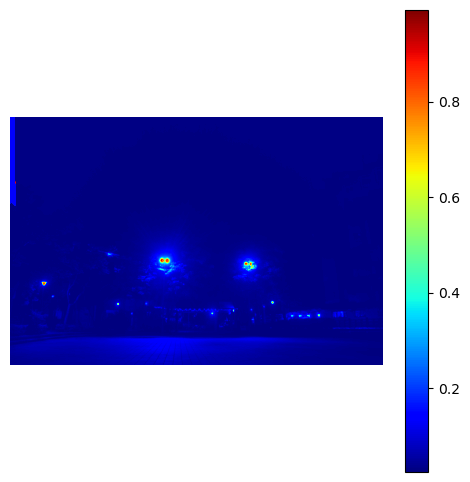

In [54]:
if __name__ == '__main__':
    folder = "testing_image" # for now
    images = load_images(folder)
    #images = np.array(images)
    aligned_images = np.array(mtb_align_images(images))
    num_samples = 500 # for now

    # z0 = sample_pixels(images[:,:,:,0], num_samples)
    # z1 = sample_pixels(images[:,:,:,1], num_samples)
    # z2 = sample_pixels(images[:,:,:,2], num_samples)
    z0 = sample_pixels(aligned_images[:,:,:,0], num_samples)
    z1 = sample_pixels(aligned_images[:,:,:,1], num_samples)
    z2 = sample_pixels(aligned_images[:,:,:,2], num_samples)
    
    exposure_times = [1, 1/1.3, 1/1.6, 1/2, 1/2.5, 1/3, 1/4, 1/5, 1/6, 1/8, 1/10, 1/13, 1/15, 1/20, 1/25, 1/30, 1/40, 1/50] # for now
    
    ln_t = [math.log(exposure_times[i]) for i in range(18)]
    
    lambda_ =50 # for now
    w = [value if value <= 0.5*255 else 255-value for value in range(256)]
    
    gB, _ = solve_respond_curve(z0, ln_t, lambda_, w)
    gG, _ = solve_respond_curve(z1, ln_t, lambda_, w)
    gR, _ = solve_respond_curve(z2, ln_t, lambda_, w)
    

    plt.figure(figsize=(6, 6))
    plt.plot(gR, range(256), 'rx')
    plt.plot(gG, range(256), 'gx')
    plt.plot(gB, range(256), 'bx')
    plt.ylabel('pixel value Z')
    plt.xlabel('log exposure X')
    plt.savefig('curve.png')

    
    hdr= show_false_color(images, gB, gG, gR, exposure_times)

    tone_mapping(hdr)

    # Convert to LDR image using linear tone mapping algorithm
    tonemapped_image = cv.createTonemapReinhard(gamma=1.8, intensity=0.5, light_adapt=0.5, color_adapt=1.2).process(hdr)

    # Save tonemapped image
    cv.imwrite('result.png', tonemapped_image * 255)
    



    
    
    